In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error,mean_squared_error, mean_squared_log_error


from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
DATAPATH = '/content/extract-na-user-activity.csv'

data = pd.read_csv(DATAPATH, index_col=['time'], parse_dates=['time'])
data.head(10)

,value
time,
2021-08-13 14:00:00+00:00,800
2021-08-13 16:00:00+00:00,732
2021-08-13 18:00:00+00:00,750
2021-08-13 20:00:00+00:00,508
2021-08-13 22:00:00+00:00,367
2021-08-14 00:00:00+00:00,202
2021-08-14 02:00:00+00:00,28
2021-08-14 04:00:00+00:00,53
2021-08-14 06:00:00+00:00,399


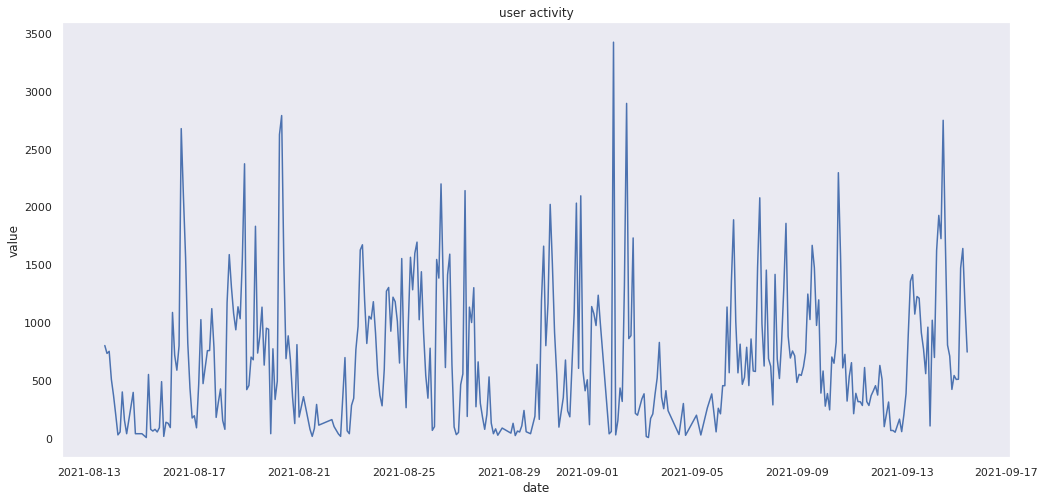

In [ ]:
plt.figure(figsize=(17, 8))
plt.plot(data.value)
plt.title('user activity')
plt.ylabel('value')
plt.xlabel('date')
plt.grid(False)
plt.show()

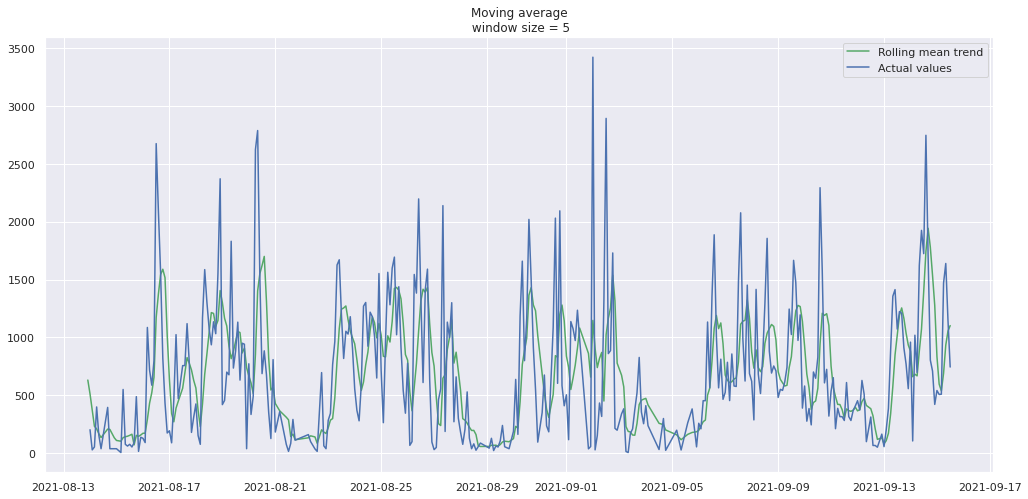

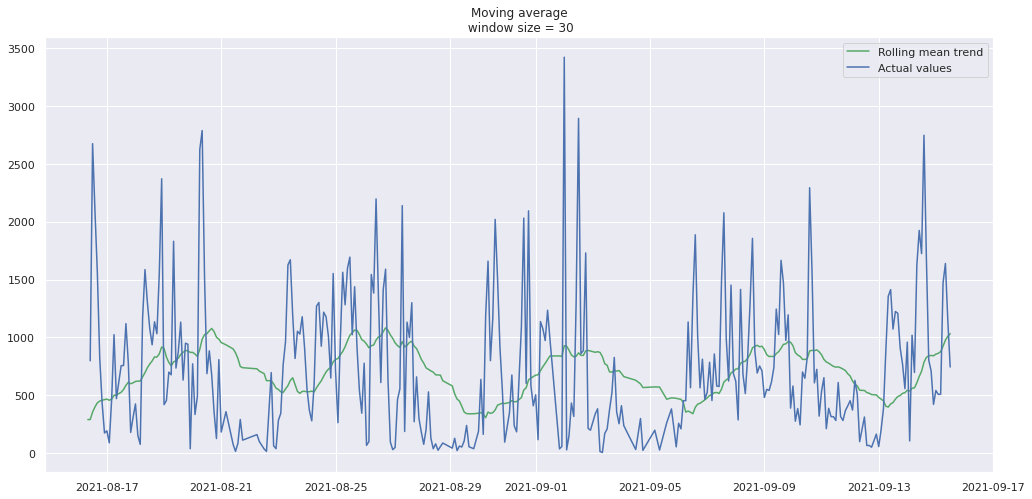

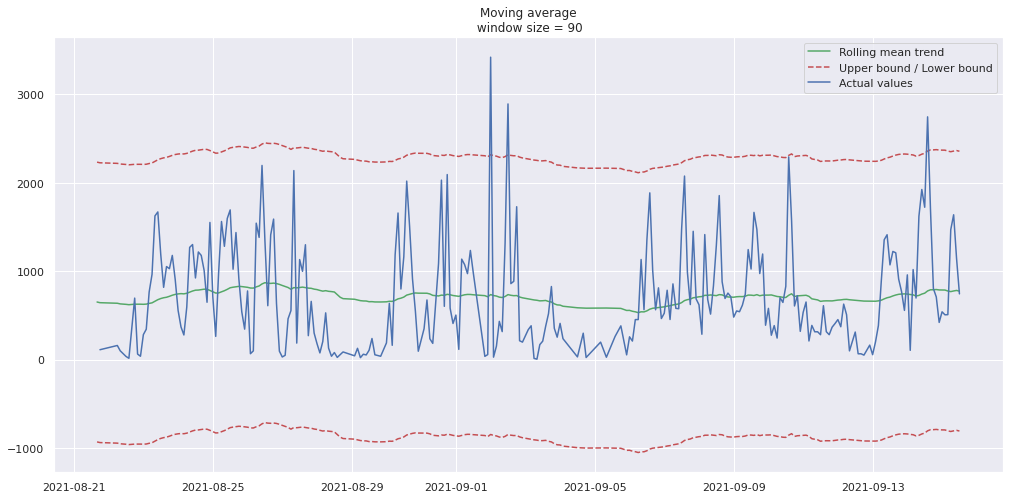

In [ ]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(data.value, 5)

#Smooth by the previous month (30 days)
plot_moving_average(data.value, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(data.value, 90, plot_intervals=True)

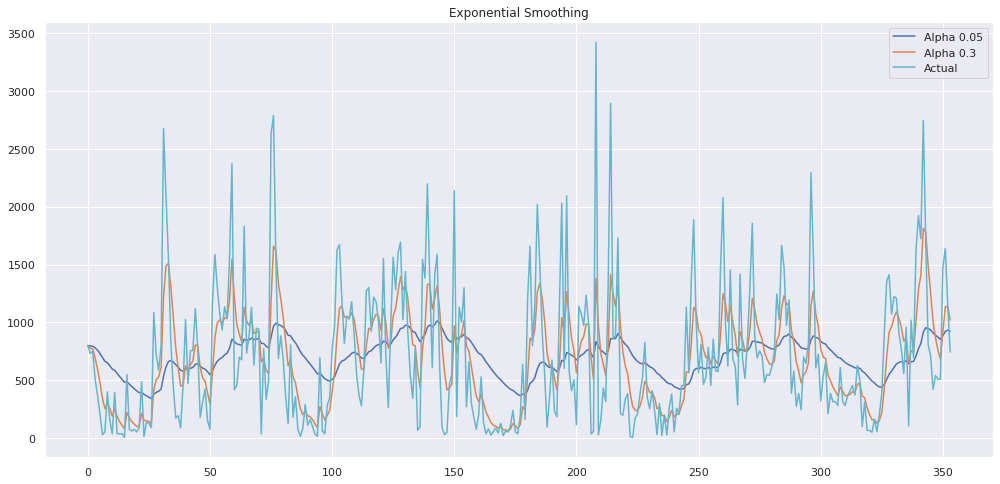

In [ ]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(data.value, [0.05, 0.3])

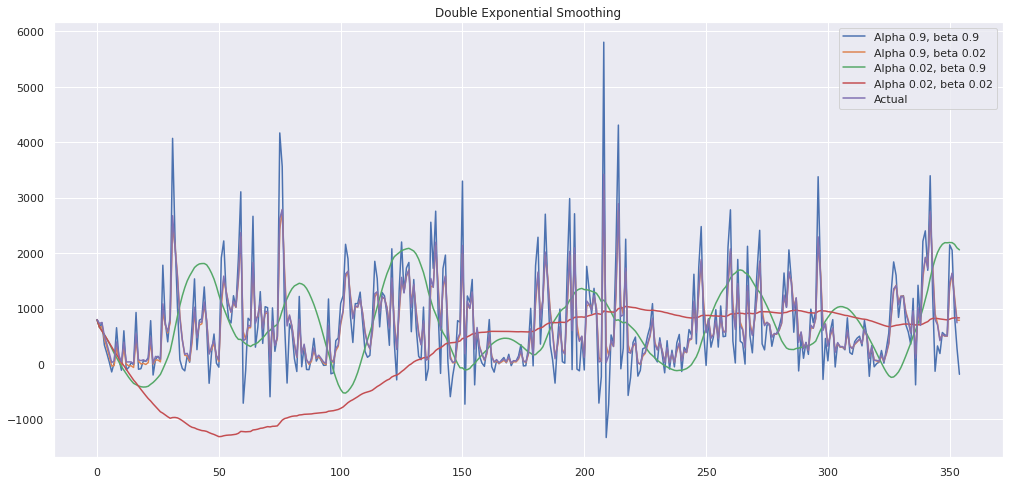

In [ ]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(data.value, alphas=[0.9, 0.02], betas=[0.9, 0.02])

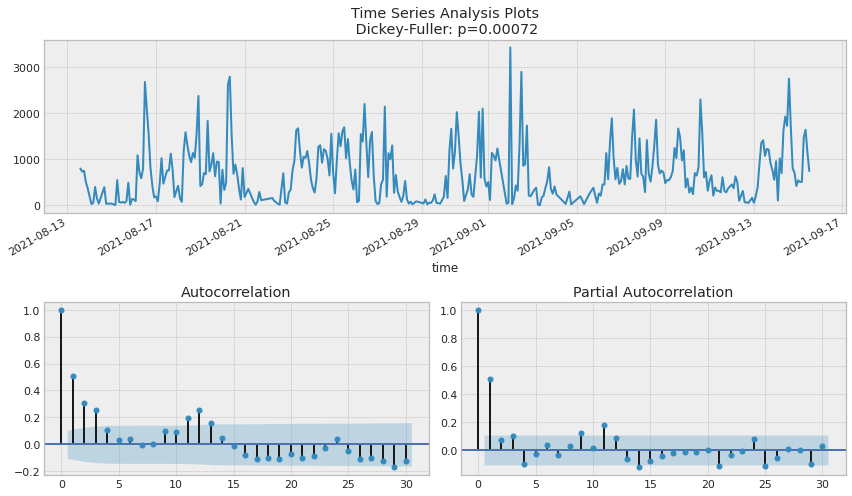

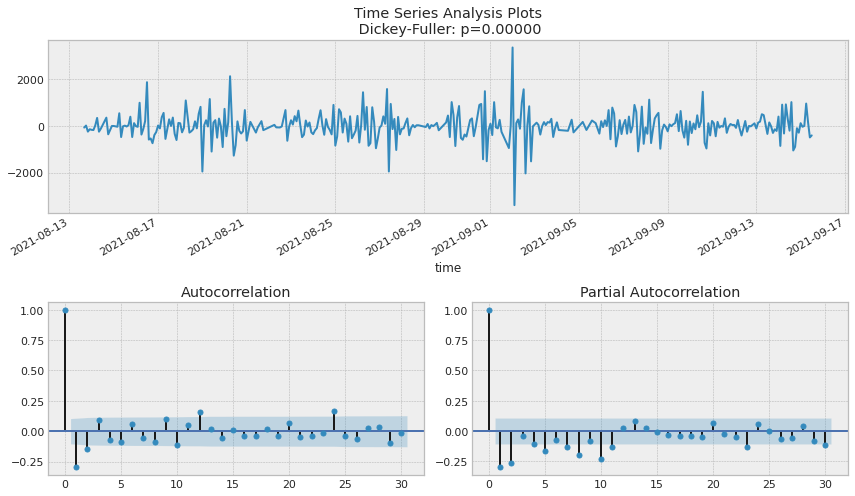

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data.value, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = data.value - data.value.shift(1)

tsplot(data_diff[1:], lags=30)

In [ ]:
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5
ps,qs,Ps,Qs



(range(0, 5), range(0, 5), range(0, 5), range(0, 5))

In [ ]:
#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)
parameters_list



[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 0, 2),
 (0, 0, 0, 3),
 (0, 0, 0, 4),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 0, 1, 2),
 (0, 0, 1, 3),
 (0, 0, 1, 4),
 (0, 0, 2, 0),
 (0, 0, 2, 1),
 (0, 0, 2, 2),
 (0, 0, 2, 3),
 (0, 0, 2, 4),
 (0, 0, 3, 0),
 (0, 0, 3, 1),
 (0, 0, 3, 2),
 (0, 0, 3, 3),
 (0, 0, 3, 4),
 (0, 0, 4, 0),
 (0, 0, 4, 1),
 (0, 0, 4, 2),
 (0, 0, 4, 3),
 (0, 0, 4, 4),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 0, 2),
 (0, 1, 0, 3),
 (0, 1, 0, 4),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (0, 1, 1, 2),
 (0, 1, 1, 3),
 (0, 1, 1, 4),
 (0, 1, 2, 0),
 (0, 1, 2, 1),
 (0, 1, 2, 2),
 (0, 1, 2, 3),
 (0, 1, 2, 4),
 (0, 1, 3, 0),
 (0, 1, 3, 1),
 (0, 1, 3, 2),
 (0, 1, 3, 3),
 (0, 1, 3, 4),
 (0, 1, 4, 0),
 (0, 1, 4, 1),
 (0, 1, 4, 2),
 (0, 1, 4, 3),
 (0, 1, 4, 4),
 (0, 2, 0, 0),
 (0, 2, 0, 1),
 (0, 2, 0, 2),
 (0, 2, 0, 3),
 (0, 2, 0, 4),
 (0, 2, 1, 0),
 (0, 2, 1, 1),
 (0, 2, 1, 2),
 (0, 2, 1, 3),
 (0, 2, 1, 4),
 (0, 2, 2, 0),
 (0, 2, 2, 1),
 (0, 2, 2, 2),
 (0, 2, 2, 3),
 (0, 2, 2, 4),
 (0, 2, 3, 0),
 (0, 2, 3,

In [ ]:
# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(data.value, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        print(model.aic,param)
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(data.value, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

  0%|          | 0/625 [00:00<?, ?it/s]

5714.0491072691375 (0, 0, 0, 0)
5466.287211957209 (0, 0, 0, 1)
5465.396218272454 (0, 0, 0, 2)
5464.263636607796 (0, 0, 0, 3)
5466.13075530616 (0, 0, 0, 4)
5621.828772775626 (0, 0, 1, 0)
5466.014447051836 (0, 0, 1, 1)
5470.111600010245 (0, 0, 1, 2)
5466.211675088181 (0, 0, 1, 3)
5468.258411460925 (0, 0, 1, 4)
5563.825324798896 (0, 0, 2, 0)
5463.72797651737 (0, 0, 2, 1)
5465.723895693032 (0, 0, 2, 2)
5469.744964254969 (0, 0, 2, 3)
5475.291323068455 (0, 0, 2, 4)
5525.293786795302 (0, 0, 3, 0)
5465.7194436175905 (0, 0, 3, 1)
5467.656374865759 (0, 0, 3, 2)
5474.5103234897715 (0, 0, 3, 3)
5473.67577872443 (0, 0, 3, 4)
5515.231098584995 (0, 0, 4, 0)
5466.444860478298 (0, 0, 4, 1)
5469.665331888296 (0, 0, 4, 2)
5473.6899563778115 (0, 0, 4, 3)
5473.95332743759 (0, 0, 4, 4)
5678.028496702989 (0, 1, 0, 0)
5412.377370810347 (0, 1, 0, 1)
5402.949907072005 (0, 1, 0, 2)
5404.439520040918 (0, 1, 0, 3)
5406.20733253645 (0, 1, 0, 4)
5559.648124473409 (0, 1, 1, 0)
5404.238771899441 (0, 1, 1, 1)
5415.8582

In [ ]:
def plot_SARIMA(series, model, n_steps):
    """
        Plot model vs predicted values
        
        series - dataset with time series
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
    """
    
    data = series.copy().rename(columns = {'value': 'actual'})
    data['arima_model'] = model.fittedvalues
    #Make a shift on s+d steps, because these values were unobserved by the model due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    #Forecast on n_steps forward
    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
    forecast = data.arima_model.append(forecast)
    #Calculate error
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(17, 8))
    plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(error))
    plt.plot(forecast, color='r', label='model')
    plt.axvspan(data.index[-1], forecast.index[-1],alpha=0.5, color='lightgrey')
    plt.plot(data, label='actual')
    plt.legend()
    plt.grid(True);
    
# plot_SARIMA(data, best_model, 5)
print(best_model.predict(start=data.value.shape[0]-5, end=data.value.shape[0] ))
print(mean_absolute_percentage_error(data.value[s+d:], best_model.fittedvalues[s+d:]))

349     617.982267
350     579.628762
351    1067.932133
352    1226.200398
353    1113.277661
354     859.942859
dtype: float64
247.41254863577632


In [ ]:
data.value.shape[0]

354

In [ ]:
data.value[:6]

time
2021-08-13 14:00:00+00:00    800
2021-08-13 16:00:00+00:00    732
2021-08-13 18:00:00+00:00    750
2021-08-13 20:00:00+00:00    508
2021-08-13 22:00:00+00:00    367
2021-08-14 00:00:00+00:00    202
Name: value, dtype: int64

In [ ]:
data.value

time
2021-08-13 14:00:00+00:00     800
2021-08-13 16:00:00+00:00     732
2021-08-13 18:00:00+00:00     750
2021-08-13 20:00:00+00:00     508
2021-08-13 22:00:00+00:00     367
                             ... 
2021-09-15 04:00:00+00:00     509
2021-09-15 06:00:00+00:00    1470
2021-09-15 08:00:00+00:00    1639
2021-09-15 10:00:00+00:00    1148
2021-09-15 12:00:00+00:00     744
Name: value, Length: 354, dtype: int64

In [ ]:
#Make a dataframe containing actual and predicted prices
comparison = pd.DataFrame({'actual': [509,1470,1639,1148,744,507],
                          'predicted': [859.94,1113.27,1226.200,1067.93,579.62,617.98],
                           "hours":[2.00,4.00,6.00,8.00,10.00,12.00]})
comparison



,actual,predicted,hours
0,509,859.94,2.0
1,1470,1113.27,4.0
2,1639,1226.20,6.0
3,1148,1067.93,8.0
4,744,579.62,10.0
5,507,617.98,12.0


In [ ]:
#mape=mean_absolute_percentage_error(comparison["actual"],comparison["predicted"])
#mape

28.226460313231662

In [ ]:
 comparison.set_index("hours",inplace=True)

No handles with labels found to put in legend.


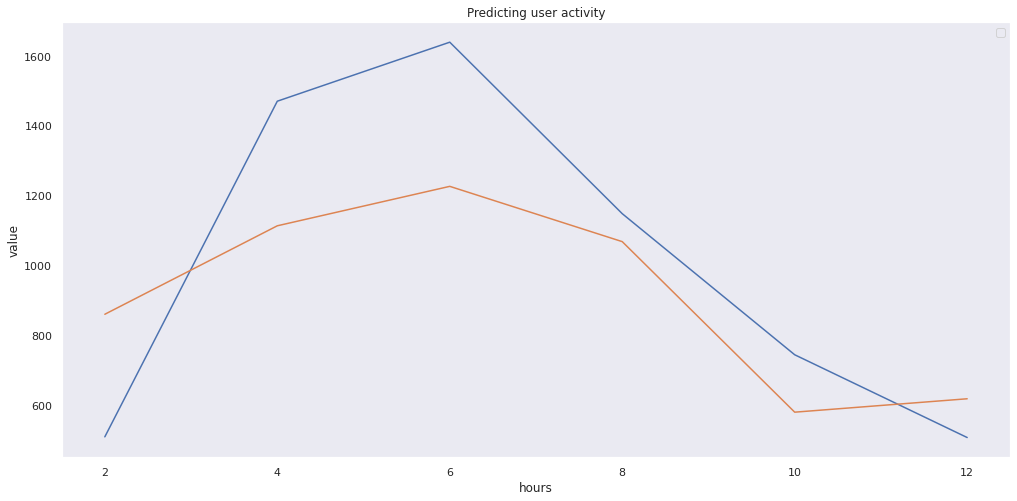

In [ ]:
#Plot predicted vs actual price

plt.figure(figsize=(17, 8))
plt.plot(comparison.actual)
plt.plot(comparison.predicted)
plt.title('Predicting user activity')
plt.ylabel('value')
plt.xlabel('hours')
plt.legend(loc='best')
plt.grid(False)
plt.show()